config

In [2]:
import psycopg2
import random
import json
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.decomposition import SparsePCA,PCA
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,precision_score,recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix


from sklearn import tree

In [3]:
def getdata(query):
    with open('config.json', 'r') as f:
        config_dict = json.load(f)
    #print(config_dict)
    #print(config_dict['password'])
    record = 0
    #string = "user=config_dict['user'] password = config_dict['password'] host = config_dict['host'] dbname = config_dict['dbname'] port = config_dict['port']"
    try:
        connection = psycopg2.connect(user=config_dict['user'],
                                      password=config_dict['password'],
                                      host=config_dict['host'],
                                      dbname=config_dict['dbname'],
                                      port=config_dict['port'])
        cursor = connection.cursor()
        # Print PostgreSQL Connection properties
        print ( connection.get_dsn_parameters(),"\n")
        # Print PostgreSQL version
        #cursor.execute("SELECT version();")
        cursor.execute(query)
        record = cursor.fetchall()
        #print("You are connected to - ", record,"\n")
    except (Exception, psycopg2.Error) as error :
        print ("Error while connecting to PostgreSQL", error)
    finally:
        #closing database connection.
            if(connection):
                cursor.close()
                connection.close()
                print("PostgreSQL connection is closed")
    return record;

t-sne and decision tree

In [4]:
import openTSNE
query = '''(SELECT TOP 3000
total_referrer_views,
total_detail_views,
total_report_actions,
total_search_views,
months_since_user_signup,
total_engaged_time,
total_overview_views,
total_info_views,
total_tag_views,
total_author_views,
total_section_views,
did_return_visit 
   FROM visitors_by_month
   where did_return_visit = 0 
   ORDER BY RANDOM())
UNION ALL
(SELECT TOP 3000
total_referrer_views,
total_detail_views,
total_report_actions,
total_search_views,
months_since_user_signup,
total_engaged_time,
total_overview_views,
total_info_views,
total_tag_views,
total_author_views,
total_section_views,
did_return_visit 
   FROM visitors_by_month
   where did_return_visit = 1 
   ORDER BY RANDOM());'''


data = getdata(query)
data = [[data if data is not None else 0 for data in x_i] for x_i in data]
data = [(x_i[0:len(x_i)-1],x_i[-1]) for x_i in data] 

X = [x_i[0] for x_i in data]
y = [x_i[1] for x_i in data]

# train,valid, test split




# X_train = StandardScaler(X_train)
# X_valid = StandardScaler(X_valid)


features = [
        'total_referrer_views',
        'total_detail_views',
        'total_report_actions',
        'total_search_views',
        'months_since_user_signup', 
        'total_engaged_time', 
        'total_overview_views',
        'total_info_views',
        'total_tag_views',
        'total_author_views',
        'total_section_views'
        ]
feature_ids = range(len(features))
dim = 2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

X_train = np.array(X_train)
X_valid = np.array(X_valid)

tsne = openTSNE.TSNE(n_components=dim,perplexity = 37)
embedding = tsne.fit(X_train)


{'user': 'mlcalss', 'dbname': 'nydn', 'host': 'dbt-dpl-dev.c913t1mfbggj.us-east-1.redshift.amazonaws.com', 'port': '5439', 'tty': '', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 

PostgreSQL connection is closed


/home/dima/anaconda3/lib/python3.7/site-packages/openTSNE/nearest_neighbors.py:184: UserWarning: `pynndescent` has recently changed which distance metrics are supported, and `openTSNE.nearest_neighbors` has not been updated. Please notify the developers of this change.
  "`pynndescent` has recently changed which distance metrics are supported, "
/home/dima/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:1958: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'forest' of function 'initialise_search'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py", line 72:
@numba.njit()
def initialise_search(
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


In [9]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

newX_train = embedding
newX_valid = embedding.transform(X_valid)

dtc = DecisionTreeClassifier(criterion='gini', 
                             splitter='best', 
                             max_depth=8)
dtc.fit(newX_train,y_train)
y_pred = dtc.predict(newX_valid)
print('confusion matrix', confusion_matrix(y_pred,y_valid))
print('accuracy',accuracy_score(y_pred,y_valid))
print('precision',precision_score(y_valid,y_pred))
print('recall',recall_score(y_valid,y_pred))

confusion matrix [[188 159]
 [ 82 111]]
accuracy 0.5537037037037037
precision 0.5751295336787565
recall 0.4111111111111111


[-15.58283959  -1.18707758]
0 0


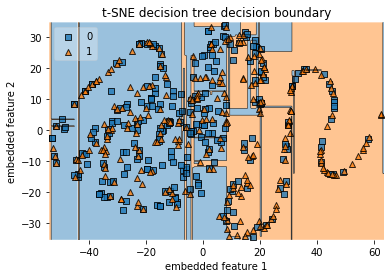

In [8]:
i = 2
print(newX_valid[i])
print(y_pred[i],y_valid[i])

from mlxtend.plotting import plot_decision_regions

plot_decision_regions(newX_valid, np.array(y_valid), clf=dtc, legend=2)
plt.title('t-SNE decision tree decision boundary')
plt.xlabel('embedded feature 1')
plt.ylabel('embedded feature 2')
plt.show()